In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
def em_algorithm(y, Z, X, max_iter=100, tol=1e-6, printInfo=True):
    n, c = Z.shape
    n, p = X.shape
    
    omega = np.zeros(c)
    sigma_beta2 = 0.3
    sigma_e2 = 1.0
    
    marginal_likelihoods = []

    XTX = X.T @ X
    ZTZ = Z.T @ Z
    I_p = np.eye(p)
    for iteration in range(max_iter):
        # E步：计算后验分布的均值和协方差矩阵
        Sigma_beta_y = np.linalg.inv(XTX / sigma_e2 + I_p / sigma_beta2)
        mu_beta_y = Sigma_beta_y @ X.T @ (y - Z @ omega) / sigma_e2
        
        # M步：更新参数
        omega_new = np.linalg.solve(ZTZ, Z.T @ (y - X @ mu_beta_y))
        sigma_beta2_new = (np.trace(Sigma_beta_y) + mu_beta_y.T @ mu_beta_y) / p
        sigma_e2_new = (np.linalg.norm(y - Z @ omega_new - X @ mu_beta_y)**2 + np.trace(XTX @ Sigma_beta_y)) / n
        
        if np.linalg.norm(omega - omega_new) < tol and abs(sigma_beta2 - sigma_beta2_new) < tol and abs(sigma_e2 - sigma_e2_new) < tol:
            break
        
        omega, sigma_beta2, sigma_e2 = omega_new, sigma_beta2_new, sigma_e2_new
        
        term1 = -0.5 * n * np.log(2 * np.pi * sigma_e2)
        term2 = -0.5 * (np.linalg.norm(y - Z @ omega - X @ mu_beta_y)**2 + np.trace(XTX @ Sigma_beta_y)) / sigma_e2
        term3 = -0.5 * p * np.log(2 * np.pi * sigma_beta2)
        term4 = -0.5 * (np.trace(Sigma_beta_y) + mu_beta_y.T @ mu_beta_y) / sigma_beta2
        marginal_likelihood = term1 + term2 + term3 + term4
        marginal_likelihoods.append(marginal_likelihood)
        if(printInfo):
            print(f"Iteration {iteration}: Marginal Likelihood = {marginal_likelihood}")
    
    return omega, sigma_beta2, sigma_e2, mu_beta_y,Sigma_beta_y, marginal_likelihoods

In [5]:
file_path = 'lmm_y_z_x.txt'
data =pd.read_csv(file_path,delim_whitespace=True)

/var/folders/vt/qwvfy06n63q184jd56rxd3dh0000gn/T/ipykernel_9174/1997787713.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data =pd.read_csv(file_path,delim_whitespace=True)


In [6]:
y = data.iloc[:, 0].values
Z = data.iloc[:, 1:11].values
X = data.iloc[:, 11:].values

In [5]:
omega, sigma_beta2, sigma_e2, mu_beta_y,Sigma_beta_y, marginal_likelihoods = em_algorithm(y, Z, X)

print(f'omega: {omega}, sigma_beta2: {sigma_beta2}, sigma_e2: {sigma_e2}, mu_beta_y: {mu_beta_y}')

Iteration 0: Marginal Likelihood = -6692.211218334929
Iteration 1: Marginal Likelihood = -6597.01051984068
Iteration 2: Marginal Likelihood = -6554.655155047307
Iteration 3: Marginal Likelihood = -6533.580707413432
Iteration 4: Marginal Likelihood = -6521.1869017611625
Iteration 5: Marginal Likelihood = -6512.3702241985475
Iteration 6: Marginal Likelihood = -6505.054035103025
Iteration 7: Marginal Likelihood = -6498.392496781383
Iteration 8: Marginal Likelihood = -6492.040998276294
Iteration 9: Marginal Likelihood = -6485.858913396297
Iteration 10: Marginal Likelihood = -6479.788515882504
Iteration 11: Marginal Likelihood = -6473.805719687923
Iteration 12: Marginal Likelihood = -6467.900074199755
Iteration 13: Marginal Likelihood = -6462.066655261502
Iteration 14: Marginal Likelihood = -6456.302784207467
Iteration 15: Marginal Likelihood = -6450.606702598074
Iteration 16: Marginal Likelihood = -6444.97703763615
Iteration 17: Marginal Likelihood = -6439.412586651136
Iteration 18: Margin

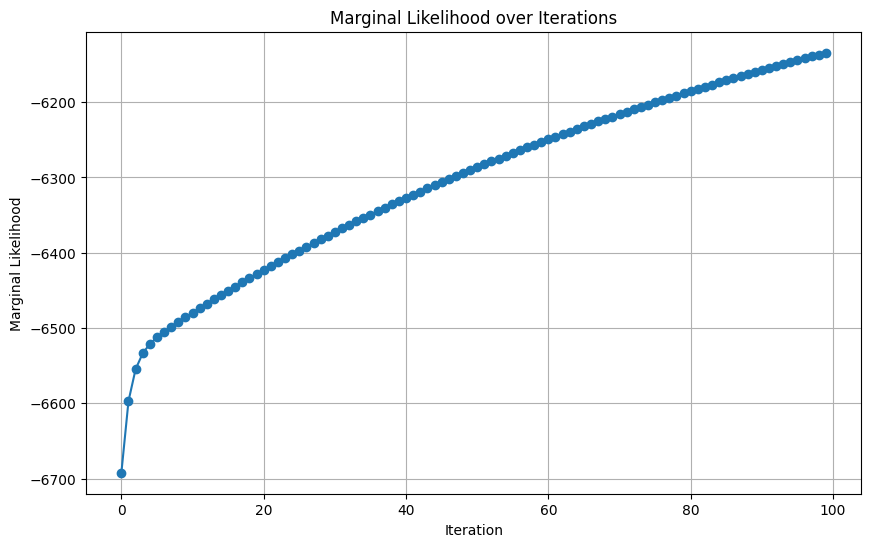

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(marginal_likelihoods, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Marginal Likelihood')
plt.title('Marginal Likelihood over Iterations')
plt.grid(True)
plt.show()

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def predict(y,Z,X):
    hat_omega, _, _, mu,_, _ = em_algorithm(y, Z, X, 50,1e-5, False)
    return np.dot(Z, hat_omega) + np.dot(X, mu)

kf = KFold(n_splits=5)
mse_list = []

for train_index, test_index in kf.split(data):
    Z_train, Z_test = Z[train_index], Z[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = predict(y_test, Z_test, X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

print("Cross-validated MSE:", np.mean(mse_list))

Cross-validated MSE: 0.51413302322149


In [9]:
def lasso_coordinate_descent_with_additional_term(X, Z, y, lambda_, num_iters=100, tol=1e-4):
    n, p = X.shape
    m = Z.shape[1]
    
    beta = np.zeros(p)
    omega = np.zeros(m)

    ZT_Z = Z.T @ Z
    XT_X = np.sum(X**2, axis=0)
    
    for _ in range(num_iters):
        beta_old = beta.copy()
        omega_old = omega.copy()
        
        # 更新 omega (ordinary least squares step)
        residual = y - X @ beta
        omega = np.linalg.solve(ZT_Z, Z.T @ residual)

        residual = y - Z @ omega
        # 更新 beta (lasso coordinate descent step)
        for j in range(p):
            rho_j = X[:, j] @ (residual - X @ beta + beta[j] * X[:, j])
            
            if rho_j < -lambda_ / 2:
                beta[j] = (rho_j + lambda_ / 2) / XT_X[j]
            elif rho_j > lambda_ / 2:
                beta[j] = (rho_j - lambda_ / 2) / XT_X[j]
            else:
                beta[j] = 0
        
        if np.sum(np.abs(beta - beta_old)) < tol and np.sum(np.abs(omega - omega_old)) < tol:
            break

    return beta, omega

lambda_ = 0.1

mse_list_lasso = []

for train_index, test_index in kf.split(data):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    Z_train, Z_test = Z[train_index], Z[test_index]
    beta, omega = lasso_coordinate_descent_with_additional_term(X_train, Z_train, y_train, lambda_)

    y_pred_lasso = Z_test@omega + X_test @ beta
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_list_lasso.append(mse_lasso)

print("Cross-validated MSE for Lasso:", np.mean(mse_list_lasso))

Cross-validated MSE for Lasso: 1.6065412528659195


In [7]:
from scipy.special import logsumexp

n, p = X.shape
mu_q = np.zeros(p)
sigma2_q = np.ones(p) + 1e-6

Theta = np.zeros(Z.shape[1] + 2)         
Theta[:-2] = np.mean(Z, axis=0)         
Theta[-2] = 1.0          
Theta[-1] = np.var(y) 

def compute_elbo(y, Z, X, mu_q, sigma2_q, Theta):
    sigma_e2 = Theta[-1]
    sigma_beta2 = Theta[-2]
    omega = Theta[:-2]

    E_log_p_y_given_beta = -0.5 * (np.sum((y - Z @ omega - X @ mu_q)**2 / sigma_e2) + len(y)*np.log(2 * np.pi * sigma_e2))
    E_log_p_beta = -0.5 * ((np.sum(mu_q**2+ sigma2_q) / sigma_beta2) +len(mu_q)* np.log(2 * np.pi * sigma_beta2))
    E_log_q_beta = -0.5 * (np.sum(np.log(sigma2_q) + 1) + len(mu_q)*np.log(2 * np.pi))

    return E_log_p_y_given_beta + E_log_p_beta - E_log_q_beta


In [10]:
num_iters = 100
elbo_values = []

for iter in range(num_iters):
    # E步：更新变分分布的参数
    for j in range(p):
        residual = y - Z @ Theta[:-2] - X @ mu_q + mu_q[j] * X[:, j]
        X_j_sq_sum = X[:, j] @ X[:, j]
        mu_q[j] = residual @ X[:, j] / (X_j_sq_sum + Theta[-1] / sigma2_q[j])
        sigma2_q[j] = Theta[-1] / (X_j_sq_sum + Theta[-1] / sigma2_q[j])
    
    # M步：更新模型参数
    # 更新 omega
    Theta[:-2] = np.linalg.solve(Z.T @ Z, Z.T @ (y - X @ mu_q))
    # 更新 sigma_\beta^2 和 sigma_e^2
    Theta[-2] = np.mean(sigma2_q + mu_q**2)
    Theta[-1] = np.mean((y - Z @ Theta[:-2] - X @ mu_q)**2)

    elbo = compute_elbo(y, Z, X, mu_q, sigma2_q, Theta)
    elbo_values.append(elbo)
    
    print(f"Iteration {iter}: ELBO = {elbo}")

Iteration 0: ELBO = -2835.1260302449946
Iteration 1: ELBO = -2835.2891121152225
Iteration 2: ELBO = -2835.449589929699
Iteration 3: ELBO = -2835.6075264152246
Iteration 4: ELBO = -2835.7629822799713
Iteration 5: ELBO = -2835.916016294672
Iteration 6: ELBO = -2836.0666853698826
Iteration 7: ELBO = -2836.215044629572
Iteration 8: ELBO = -2836.3611474812
Iteration 9: ELBO = -2836.5050456825365
Iteration 10: ELBO = -2836.6467894053294
Iteration 11: ELBO = -2836.7864272960487
Iteration 12: ELBO = -2836.924006533837
Iteration 13: ELBO = -2837.0595728858343
Iteration 14: ELBO = -2837.1931707599733
Iteration 15: ELBO = -2837.3248432554487
Iteration 16: ELBO = -2837.4546322109063
Iteration 17: ELBO = -2837.582578250533
Iteration 18: ELBO = -2837.7087208281077
Iteration 19: ELBO = -2837.8330982691464
Iteration 20: ELBO = -2837.9557478112347
Iteration 21: ELBO = -2838.0767056426166
Iteration 22: ELBO = -2838.1960069391644
Iteration 23: ELBO = -2838.3136858997614
Iteration 24: ELBO = -2838.4297757

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(elbo_values, marker='o')
plt.title("ELBO over Iterations")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.show()

In [13]:
print("Posterior mean of beta (MFVI):", mu_q)
print("Posterior mean of beta (EM):", mu_beta_y)
print("Posterior variance of beta (MFVI):", sigma2_q)
print("Posterior variance of beta (EM):", Sigma_beta_y)

Posterior mean of beta (MFVI): [ 0.01638252 -0.00762575  0.00598874 ...  0.01162771 -0.00946914
 -0.0031193 ]
Posterior mean of beta (EM): [ 0.18658653 -0.05363353  0.08549908 ...  0.13665655 -0.10486828
 -0.0293475 ]
Posterior variance of beta (MFVI): [0.01884627 0.01922537 0.02093188 ... 0.01937942 0.01946325 0.01926681]
Posterior variance of beta (EM): [[ 2.20382462e-01  1.53737313e-04 -3.23843430e-04 ...  7.48272449e-05
  -1.01451197e-03  3.98795616e-05]
 [ 1.53737313e-04  2.20507190e-01 -7.33371653e-04 ... -1.19763256e-04
   3.51328373e-04  9.31449716e-04]
 [-3.23843430e-04 -7.33371653e-04  2.22278315e-01 ... -4.77913700e-04
   8.12280471e-05  1.56887935e-04]
 ...
 [ 7.48272449e-05 -1.19763256e-04 -4.77913700e-04 ...  2.20829305e-01
  -2.06412882e-04  4.99849942e-04]
 [-1.01451197e-03  3.51328373e-04  8.12280471e-05 ... -2.06412882e-04
   2.20888312e-01  8.72559988e-04]
 [ 3.98795616e-05  9.31449716e-04  1.56887935e-04 ...  4.99849942e-04
   8.72559988e-04  2.20761098e-01]]
